# Import packages

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory

**Loading train features csv**

In [2]:
df_train_feats = pd.read_csv('data/train_features.csv', index_col = 'id')
df_train_feats.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


**Loading labels csv**

In [4]:
df_train_labels = pd.read_csv('data/train_labels.csv', index_col = 'id')
df_train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Converting labels dataframe to numpy for later zipping
train_labels_np = df_train_labels.to_numpy()

In [6]:
train_labels_np

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

I use the ```image_dataset_from_directory``` function from keras to create a image_data dataset. Important: I have set labels to None and shuffle to False. I then zip the dataset containing the images with the labels numpy array.

In [7]:
filepath = 'data/train_features/'
image_data = image_dataset_from_directory(filepath, 
                                          labels = None, 
                                          color_mode = 'rgb', 
                                          batch_size = 32, 
                                          image_size = (320, 240),
                                          shuffle = False)

# Zip the image dataset with the labels
image_data = tf.data.Dataset.zip((image_data, tf.data.Dataset.from_tensor_slices(train_labels_np)))

# Optionally, batch the dataset if it's not already batched
#image_data = image_data.batch(32)



Found 16488 files belonging to 1 classes.


2024-08-30 15:43:24.534956: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-30 15:43:24.534982: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-30 15:43:24.534992: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-30 15:43:24.535178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-30 15:43:24.535195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The image_data is now a ZipDataset containing two tensors per element: one with the image and one with the labels

In [8]:
image_data

<_ZipDataset element_spec=(TensorSpec(shape=(320, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [9]:
# Take one element from the dataset
for image, label in image_data.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())  # Convert the label tensor to a numpy array for easier viewing


Image shape: (320, 240, 3)
Label: [0. 1. 0. 0. 0. 0. 0. 0.]


(-0.5, 239.5, 319.5, -0.5)

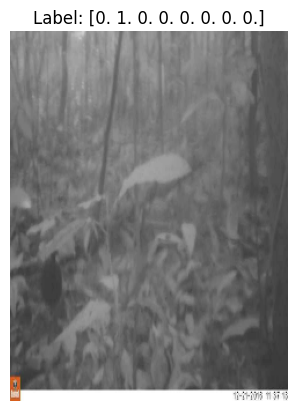

In [10]:
import matplotlib.pyplot as plt

image = image.numpy().astype("uint8")
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')

In [17]:

### This is an edited version by our friend of Tetyana's function below

def crop_white_bottom_from_image(img, check_height=8, check_width=10, start_from=60, threshold=230):
    # Converting image tensor to numpy arrray
    img_np = img.numpy()
    
    # Dimensions:
    width, height, _ = img_np.shape

    # Define the region to check for white color
    region = img_np[height - check_height:height, start_from:start_from + check_width]
    
    # check for white pixels
    white_pixels = np.all(region >= threshold, axis = -1)

    # crop
    if np.all(white_pixels):
        img_np = img_np[:height - check_height - 8, :,:]

    return img_np

''' 
### This is Tetyana's function for cropping the white line from the bottom of the images.

# Define the range of white color
def is_white_color(color, threshold=230):
    # Check if color is close to white within the given threshold
    return all(c >= threshold for c in color)

def crop_white_bottom_from_image(img, height_to_check=8, check_width=10, start_from=60, threshold=230):
    width, height = img.size
    # Define the region to check for white color
    box = (start_from, height - height_to_check, start_from + check_width, height)
    region = img.crop(box)
    # Convert the region to a NumPy array for easy processing
    region_np = np.array(region)
    # Check if all pixels in the region are close to white
    white_pixels = np.apply_along_axis(is_white_color, 1, region_np)
    
    if np.all(white_pixels):
        # Crop the bottom 16 pixels
        img = img.crop((0, 0, width, height - height_to_check - 8))
    return img.numpy
'''

# This additional function wraps the image processing function above and makes sure to apply it to the dataset together with the labels.
def crop_image_and_label(image, label):
    # Apply the cropping function to the image
    cropped_image = tf.py_function(crop_white_bottom_from_image, [image], tf.uint8) 
    return cropped_image, label

# Apply the cropping function to the dataset
cropped_dataset_with_labels = image_data.map(crop_image_and_label)


Image shape: (320, 240, 3)
Label: [0. 1. 0. 0. 0. 0. 0. 0.]


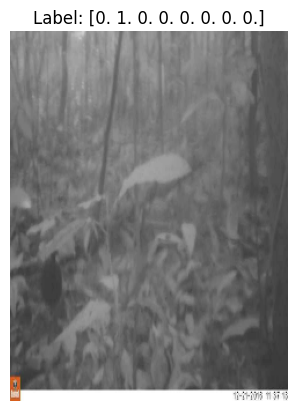

In [18]:
for image, label in cropped_dataset_with_labels.take(1):    
    print("Image shape:", image.shape)
    print("Label:", label.numpy())  # Convert the label tensor to a numpy array for easier viewing
    image = image.numpy().astype("uint8")
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

(-0.5, 239.5, 319.5, -0.5)

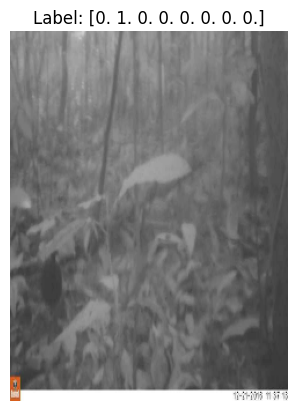

In [15]:
image = image.numpy().astype("uint8")
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')